In [9]:
import cvxpy as cp
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cycler import cycler
from pairwise_comparison import *

In [10]:
def evaluate_metrics(n_values, m_values, eps_values, L=5, repetitions=1):
    records = []
    for n in n_values:
        k = n // 4
        for m in m_values:
            for eps in eps_values:
                metrics = []
                for _ in range(repetitions):
                    theta_true = np.concatenate((np.zeros(k),
                        np.log(np.random.uniform(0.2, 0.7, n-k))
                    ))
                    gamma = 8 * 0.25 * L / eps
                    lam   = 8 * 1    * L / eps
                    noise = np.random.laplace(loc=0, scale=lam, size=n)
                    noise_count = np.random.laplace(loc=0, scale=lam/8, size=n)
                    model = individualDP(n=n, k=m, L=L, theta_true=theta_true)
                    model.fit(gamma=gamma, noise=noise)
                    pred = model.get_theta()
                    
                    # fit_by_count modifies model.topk_vector
                    model.fit_by_count(noise_count, k, select="top")
                    pred_vec = model.get_topk_vector()
                    
                    # Compute true top-k selection vector in-line
                    idx = np.argpartition(theta_true, k)[-k:]
                    true_vec = np.zeros_like(theta_true, dtype=int)
                    true_vec[idx] = 1

                    metrics.append((
                        relative_l2(pred, theta_true),
                        relative_l_inf(pred, theta_true),
                        hit_at_k(pred, theta_true, k),
                        hit_at_k_by_count(pred_vec, true_vec, k)
                    ))
                arr = np.array(metrics)
                r2_mean, rinf_mean, hit_mean, hit_by_count_mean = arr.mean(axis=0)
                r2_std,  rinf_std,  hit_std,  hit_by_count_std  = arr.std(axis=0)
                records.append({
                    'n': n,
                    'm': m,
                    'eps': eps,
                    'relative_l2_mean':    r2_mean,
                    'relative_l2_std':     r2_std,
                    'relative_l_inf_mean': rinf_mean,
                    'relative_l_inf_std':  rinf_std,
                    'hit_at_k_mean':       hit_mean,
                    'hit_at_k_std':        hit_std,
                    'hit_at_k_by_count_mean': hit_by_count_mean,
                    'hit_at_k_by_count_std':  hit_by_count_std,
                })
    return pd.DataFrame(records).set_index(['n', 'm', 'eps'])

## 1. Varying number of items

In [33]:
m_fixed    = 1000
n_values   = [12, 16, 20, 24, 28, 32]
eps_values = [0.5, 1, 2.5, np.inf]
repetitions = 200

# evaluate
df = evaluate_metrics(n_values, [m_fixed], eps_values, repetitions=repetitions)



### 1.1 L2 loss

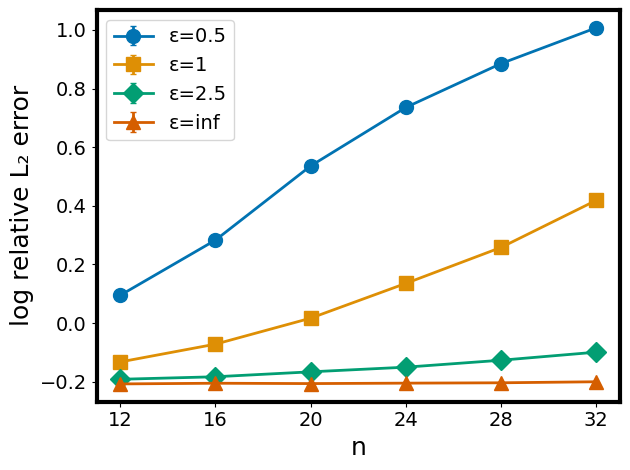

In [34]:
# slice for m = m_fixed and pivot mean & std for relative_l2
df_m        = df.xs(m_fixed, level='m').reset_index()
pivot_mean  = df_m.pivot(index='n', columns='eps', values='relative_l2_mean')
pivot_std   = df_m.pivot(index='n', columns='eps', values='relative_l2_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    0.5: 'o',   # circle
    1: 's',   # square
    2.5: 'D',   # diamond
    float('inf'): '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for eps in eps_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[eps],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[eps],
        markersize=marker_size,
        linestyle='-',
        label=f'ε={eps}',
        capsize=2
    )

plt.xlabel('n')
plt.ylabel('log relative L₂ error')
plt.xticks(n_values)      # x-ticks at the actual n values
#plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-n/l_2_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 1.2 L-inf loss

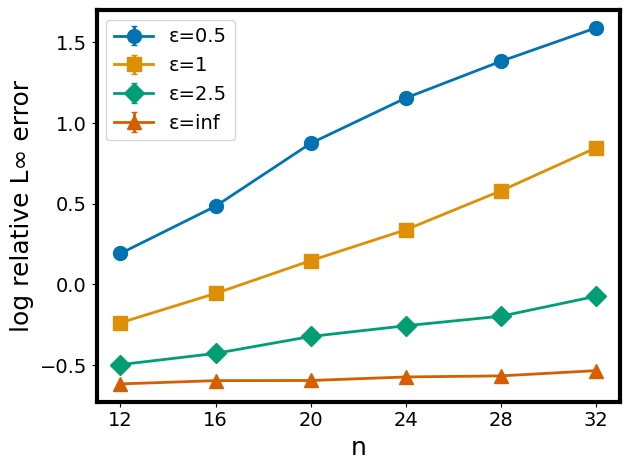

In [35]:
# slice for m = m_fixed and pivot mean & std for relative_l2
df_m        = df.xs(m_fixed, level='m').reset_index()
pivot_mean  = df_m.pivot(index='n', columns='eps', values='relative_l_inf_mean')
pivot_std   = df_m.pivot(index='n', columns='eps', values='relative_l_inf_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    0.5: 'o',   # circle
    1: 's',   # square
    2.5: 'D',   # diamond
    float('inf'): '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for eps in eps_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[eps],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[eps],
        markersize=marker_size,
        linestyle='-',
        label=f'ε={eps}',
        capsize=2
    )

plt.xlabel('n')
plt.ylabel('log relative L∞ error')
plt.xticks(n_values)      # x-ticks at the actual n values
#plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-n/l_inf_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 1.3 Hamming by estimation

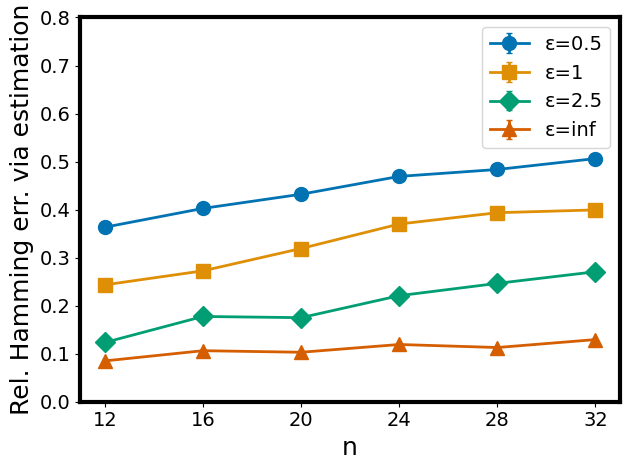

In [36]:
# slice for m = m_fixed and pivot mean & std for relative_l2
df_m        = df.xs(m_fixed, level='m').reset_index()
pivot_mean  = df_m.pivot(index='n', columns='eps', values='hit_at_k_mean')
pivot_std   = df_m.pivot(index='n', columns='eps', values='hit_at_k_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    0.5: 'o',   # circle
    1: 's',   # square
    2.5: 'D',   # diamond
    float('inf'): '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for eps in eps_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[eps],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[eps],
        markersize=marker_size,
        linestyle='-',
        label=f'ε={eps}',
        capsize=2
    )

plt.xlabel('n')
plt.ylabel('Rel. Hamming err. via estimation')
plt.xticks(n_values)      # x-ticks at the actual n values
plt.ylim(bottom=0, top=0.8)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-n/hamming_loss_via_estimation.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 1.4 Hamming by counting

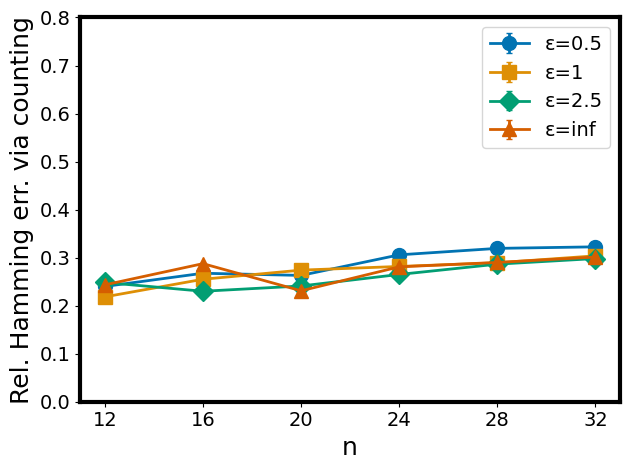

In [37]:
# slice for m = m_fixed and pivot mean & std for relative_l2
df_m        = df.xs(m_fixed, level='m').reset_index()
pivot_mean  = df_m.pivot(index='n', columns='eps', values='hit_at_k_by_count_mean')
pivot_std   = df_m.pivot(index='n', columns='eps', values='hit_at_k_by_count_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    0.5: 'o',   # circle
    1: 's',   # square
    2.5: 'D',   # diamond
    float('inf'): '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for eps in eps_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[eps],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[eps],
        markersize=marker_size,
        linestyle='-',
        label=f'ε={eps}',
        capsize=2
    )

plt.xlabel('n')
plt.ylabel('Rel. Hamming err. via counting')
plt.xticks(n_values)      # x-ticks at the actual n values
plt.ylim(bottom=0, top=0.8)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-n/hamming_loss_via_counting.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 2. Varying number of individuals

In [ ]:
m_values    = [250, 500, 750, 1000, 1500, 2000]
n_fixed   = 16
eps_values = [0.5, 1, 2.5, np.inf]
repetitions = 200

# evaluate
df = evaluate_metrics([n_fixed], m_values, eps_values, repetitions=repetitions)

### 2.1 L2 loss

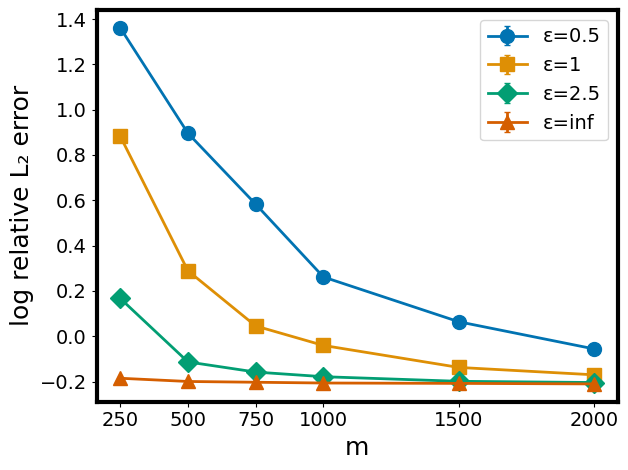

In [39]:
# slice for m = m_fixed and pivot mean & std for relative_l2
df_n        = df.xs(n_fixed, level='n').reset_index()
pivot_mean  = df_n.pivot(index='m', columns='eps', values='relative_l2_mean')
pivot_std   = df_n.pivot(index='m', columns='eps', values='relative_l2_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    0.5: 'o',   # circle
    1: 's',   # square
    2.5: 'D',   # diamond
    float('inf'): '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for eps in eps_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[eps],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[eps],
        markersize=marker_size,
        linestyle='-',
        label=f'ε={eps}',
        capsize=2
    )

plt.xlabel('m')
plt.ylabel('log relative L₂ error')
plt.xticks(m_values)      # x-ticks at the actual n values
#plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-m/l_2_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 2.2 L-inf loss

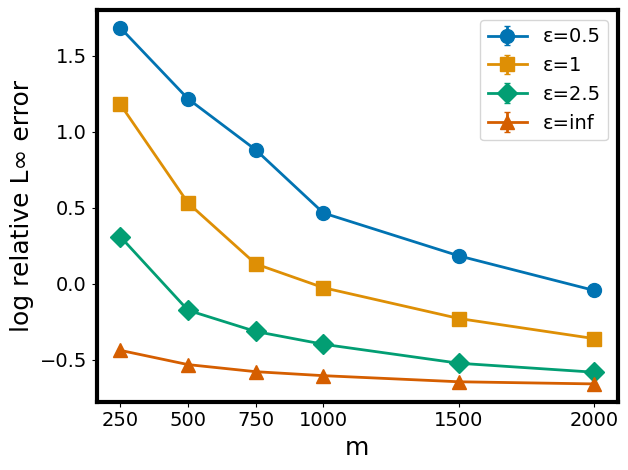

In [40]:
df_n        = df.xs(n_fixed, level='n').reset_index()
pivot_mean  = df_n.pivot(index='m', columns='eps', values='relative_l_inf_mean')
pivot_std   = df_n.pivot(index='m', columns='eps', values='relative_l_inf_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    0.5: 'o',   # circle
    1: 's',   # square
    2.5: 'D',   # diamond
    float('inf'): '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for eps in eps_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[eps],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[eps],
        markersize=marker_size,
        linestyle='-',
        label=f'ε={eps}',
        capsize=2
    )

plt.xlabel('m')
plt.ylabel('log relative L∞ error')
plt.xticks(m_values)      # x-ticks at the actual n values
#plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-m/l_inf_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 2.3 Hamming by estimation

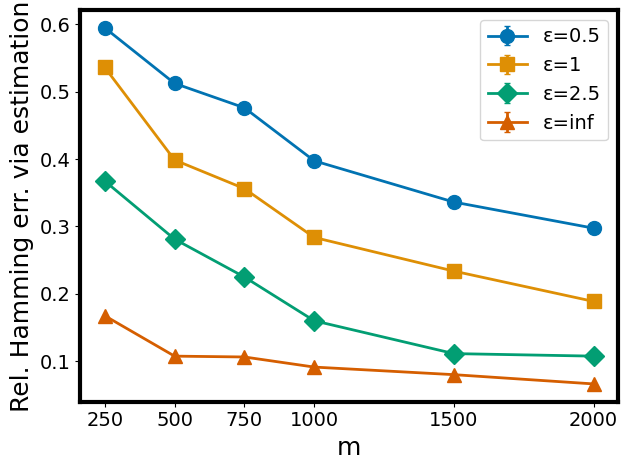

In [41]:
df_n        = df.xs(n_fixed, level='n').reset_index()
pivot_mean  = df_n.pivot(index='m', columns='eps', values='hit_at_k_mean')
pivot_std   = df_n.pivot(index='m', columns='eps', values='hit_at_k_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    0.5: 'o',   # circle
    1: 's',   # square
    2.5: 'D',   # diamond
    float('inf'): '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for eps in eps_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[eps],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[eps],
        markersize=marker_size,
        linestyle='-',
        label=f'ε={eps}',
        capsize=2
    )

plt.xlabel('m')
plt.ylabel('Rel. Hamming err. via estimation')
plt.xticks(m_values)      # x-ticks at the actual n values
#plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-m/hamming_loss_via_estimation.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 2.4 Hamming by counting

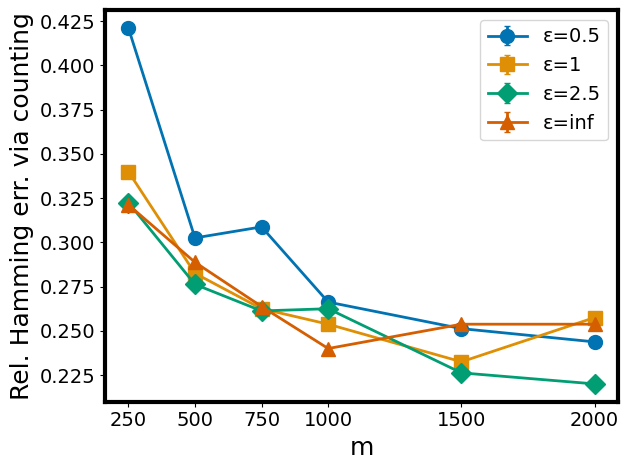

In [42]:
df_n        = df.xs(n_fixed, level='n').reset_index()
pivot_mean  = df_n.pivot(index='m', columns='eps', values='hit_at_k_by_count_mean')
pivot_std   = df_n.pivot(index='m', columns='eps', values='hit_at_k_by_count_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    0.5: 'o',   # circle
    1: 's',   # square
    2.5: 'D',   # diamond
    float('inf'): '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for eps in eps_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[eps],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[eps],
        markersize=marker_size,
        linestyle='-',
        label=f'ε={eps}',
        capsize=2
    )

plt.xlabel('m')
plt.ylabel('Rel. Hamming err. via counting')
plt.xticks(m_values)      # x-ticks at the actual n values
#plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-m/hamming_loss_via_counting.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 3. Varying privacy level

In [ ]:
m_values    = [250, 500, 1000, 2000]
n_fixed   = 16
eps_values = [0.25, 1, 2, 4, 8, 10]
repetitions = 200

# evaluate
df = evaluate_metrics([n_fixed], m_values, eps_values, repetitions=repetitions)

### 3.1 L2 loss

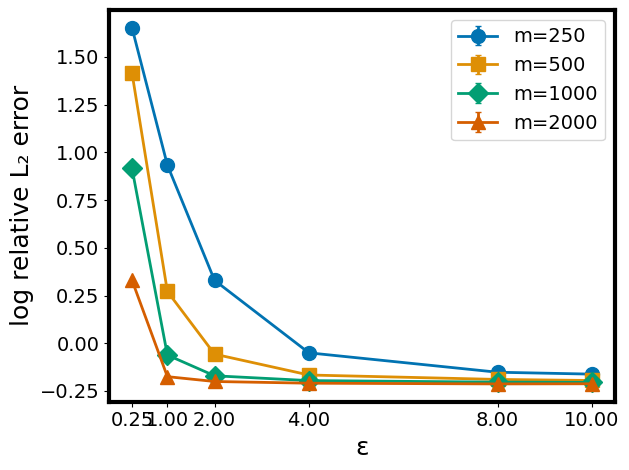

In [28]:
# slice for m = m_fixed and pivot mean & std for relative_l2
df_eps        = df.xs(n_fixed, level='n').reset_index()
pivot_mean  = df_eps.pivot(index='eps', columns='m', values='relative_l2_mean')
pivot_std   = df_eps.pivot(index='eps', columns='m', values='relative_l2_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    250: 'o',   # circle
    500: 's',   # square
    1000: 'D',   # diamond
    2000: '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for m in m_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[m],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[m],
        markersize=marker_size,
        linestyle='-',
        label=f'm={m}',
        capsize=2
    )

plt.xlabel('ε')
plt.ylabel('log relative L₂ error')
plt.xticks(eps_values)      # x-ticks at the actual n values
#plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-epsilon/l_2_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 3.2 L-inf loss

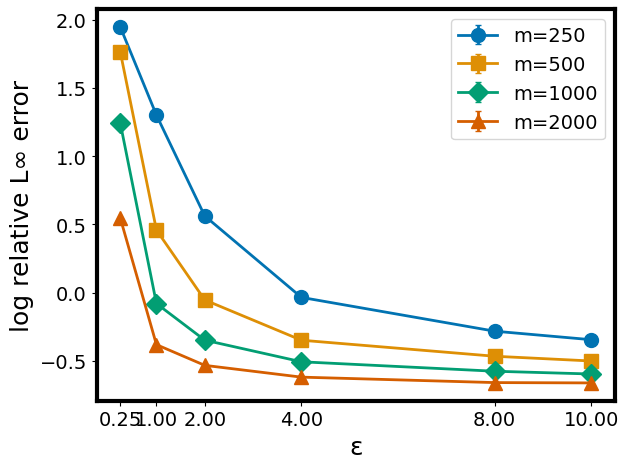

In [29]:
# slice for m = m_fixed and pivot mean & std for relative_l2
df_eps        = df.xs(n_fixed, level='n').reset_index()
pivot_mean  = df_eps.pivot(index='eps', columns='m', values='relative_l_inf_mean')
pivot_std   = df_eps.pivot(index='eps', columns='m', values='relative_l_inf_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    250: 'o',   # circle
    500: 's',   # square
    1000: 'D',   # diamond
    2000: '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for m in m_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[m],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[m],
        markersize=marker_size,
        linestyle='-',
        label=f'm={m}',
        capsize=2
    )

plt.xlabel('ε')
plt.ylabel('log relative L∞ error')
plt.xticks(eps_values)      # x-ticks at the actual n values
#plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-epsilon/l_inf_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 3.3 Hamming by estimation

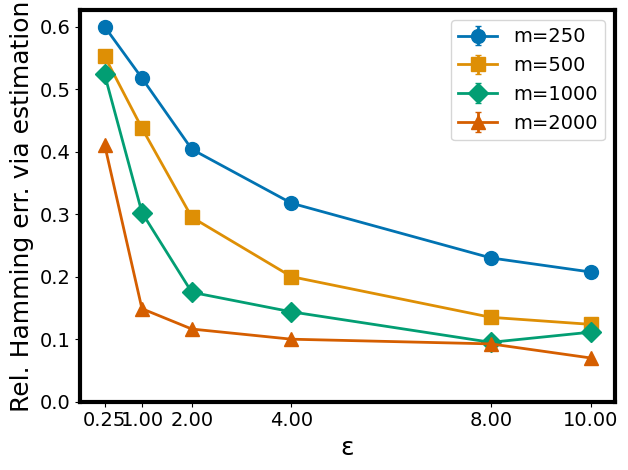

In [30]:
df_eps        = df.xs(n_fixed, level='n').reset_index()
pivot_mean  = df_eps.pivot(index='eps', columns='m', values='hit_at_k_mean')
pivot_std   = df_eps.pivot(index='eps', columns='m', values='hit_at_k_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    250: 'o',   # circle
    500: 's',   # square
    1000: 'D',   # diamond
    2000: '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for m in m_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[m],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[m],
        markersize=marker_size,
        linestyle='-',
        label=f'm={m}',
        capsize=2
    )

plt.xlabel('ε')
plt.ylabel('Rel. Hamming err. via estimation')
plt.xticks(eps_values)      # x-ticks at the actual n values
plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-epsilon/hamming_loss_via_estimation.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 3.4 Hamming by counting

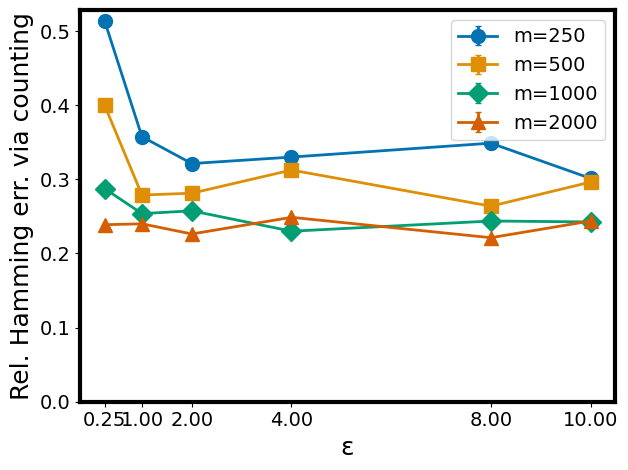

In [31]:
df_eps        = df.xs(n_fixed, level='n').reset_index()
pivot_mean  = df_eps.pivot(index='eps', columns='m', values='hit_at_k_by_count_mean')
pivot_std   = df_eps.pivot(index='eps', columns='m', values='hit_at_k_by_count_std')

# configure color-blind-friendly palette and thicker lines
cmap = plt.get_cmap('Set2')
plt.rcParams['axes.prop_cycle'] = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2

# define a distinct marker for each ε and a larger marker size
markers = {
    250: 'o',   # circle
    500: 's',   # square
    1000: 'D',   # diamond
    2000: '^'  # triangle_up
}

plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis lines
    'axes.labelsize': 18,        # x/y label font size
    'xtick.labelsize': 14,       # x-tick label size
    'ytick.labelsize': 14,       # y-tick label size
    'legend.fontsize': 14        # legend text size
})

marker_size = 10

# assume pivot_mean, pivot_std, n_values, eps_values are already defined
for m in m_values:
    plt.errorbar(
        pivot_mean.index,
        pivot_mean[m],
        #yerr=pivot_std[eps],
        yerr = 0,
        marker=markers[m],
        markersize=marker_size,
        linestyle='-',
        label=f'm={m}',
        capsize=2
    )

plt.xlabel('ε')
plt.ylabel('Rel. Hamming err. via counting')
plt.xticks(eps_values)      # x-ticks at the actual n values
plt.ylim(bottom=0)         # y-axis starts at 0
plt.legend()               # legend with different markers
plt.tight_layout()
plt.savefig('individual-accuracy-vs-epsilon/hamming_loss_via_counting.pdf', format='pdf', bbox_inches='tight')
plt.show()